## Imports

In [1]:
import numpy as np 
import pandas as pd 
import os
import re
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add, Flatten, Lambda, Reshape, BatchNormalization, concatenate, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import matplotlib.pyplot as plt
import scipy
from PIL import Image
import random
import cv2
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError, RootMeanSquaredError, Mean, binary_crossentropy, binary_accuracy
from sklearn.model_selection import train_test_split

## GPU Mounting

In [2]:
# try:
#     import google.colab
#     in_colab = True
# except ImportError:
#     in_colab = False

# if in_colab:
#     try:
#         tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#         print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
#         tf.config.experimental_connect_to_cluster(tpu)
#         tf.tpu.experimental.initialize_tpu_system(tpu)
#         tpu_strategy = tf.distribute.TPUStrategy(tpu)
#     except ValueError:
#         if 'GPU' in [gpu[-1] for gpu in tf.config.list_physical_devices('GPU')]:
#             print('Running on Google Colab GPU')
#         else:
#             print('Not connected to a TPU or GPU runtime')

# else:
#     physical_devices = tf.config.list_physical_devices('GPU')
#     print(physical_devices)
#     try:
#         if len(physical_devices):
#             for gpu in physical_devices:
#                 tf.config.experimental.set_memory_growth(gpu, enable = True)
#                 print(f"Using local GPU: {gpu}")
#             sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(log_device_placement = True))
#         else:
#             print("No local GPU found")
#     except:
#         print("Error Mounting a GPU")
        
# tf.config.set_visible_devices([], 'GPU')
# # tf.debugging.set_log_device_placement(True)

# # Create some tensors and perform an operation
# a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
# b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
# c = tf.matmul(a, b)

# print(c)

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, enable=True)

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6



In [4]:
img_shape = (400, 600)

## Test GAN Model

In [5]:
# def make_generator_model(input_shape=(img_shape[0], img_shape[1], 3)):
#     # Input layer
#     input_img = Input(shape=input_shape)

#     # Convolutional layers
#     conv1 = Conv2D(8, (3, 3), padding='same', activation='elu')(input_img)
#     conv2 = Conv2D(16, (3, 3), padding='same', activation='elu')(conv1)
#     conv3 = Conv2D(32, (3, 3), padding='same', activation='elu')(conv2)
#     conv4 = Conv2D(64, (3, 3), padding='same', activation='elu')(conv3)
#     concat1 = concatenate([conv2, conv4], axis=-1)
#     conv5 = Conv2D(64, (3, 3), padding='same', activation='elu')(concat1)
#     output_img = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(conv5)

#     # Create the model
#     generator_model = Model(inputs=input_img, outputs=output_img)
#     return generator_model

In [6]:
# generator = make_generator_model()
# generator.summary()

In [7]:
# def make_discriminator_model(input_shape=(img_shape[0], img_shape[1], 3)):
#     # Input layer
#     input_img = Input(shape=input_shape)

#     # Convolutional layers
#     conv1 = Conv2D(8, (7, 7), activation='relu')(input_img)
#     conv2 = Conv2D(16, (7, 7), activation='relu')(conv1)
#     conv3 = Conv2D(32, (7, 7), activation='relu')(conv2)
#     conv4 = Conv2D(4, (7, 7), activation='relu')(conv3)
#     maxpool1 = MaxPooling2D((7, 7))(conv4)
#     flatten = Flatten()(maxpool1)
#     output_img = Dense(1, activation='sigmoid')(flatten)

#     # Create the model
#     discriminator_model = Model(inputs=input_img, outputs=output_img)
#     return discriminator_model

In [8]:
# discriminator = make_discriminator_model()

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [10]:
# def discriminator_loss(real_output, fake_output):
#     real_loss = cross_entropy(tf.ones_like(real_output), real_output)
#     fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
#     total_loss = real_loss + fake_loss
#     return total_loss

In [11]:
# def generator_loss(fake_output):
#     return cross_entropy(tf.ones_like(fake_output), fake_output)

In [12]:
# generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Functions and callbacks

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
tensorboard = TensorBoard(log_dir='logs')

In [14]:
def plot_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [15]:
def plot_predictions(model, X, y, num_examples=5, seed = 42):
    np.random.seed(seed)
    indices = np.random.randint(0, len(X), num_examples)
    for i in indices:
        x_sample = y[i:i+1]
        y_sample = y[i:i+1]
        
        # Predict
        y_pred = model.predict(x_sample)

        # Plot
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(x_sample[0], cmap='gray')
        plt.title('Original')
        
        plt.subplot(1, 3, 2)
        plt.imshow(y_sample[0], cmap='gray')
        plt.title('Expected')
        
        plt.subplot(1, 3, 3)
        plt.imshow(y_pred[0], cmap='gray')
        plt.title('Reconstructed by Model')
        
        plt.show()

In [16]:
BATCH_SIZE = 16
EPOCHS = 100
seed = 42

## Data preparation

In [17]:
base_directory = 'data'
hires_folder = os.path.join(base_directory, 'high res')
lowres_folder = os.path.join(base_directory, 'low res')

data = pd.read_csv("data/image_data.csv")
data['low_res'] = data['low_res'].apply(lambda x: os.path.join(lowres_folder,x))
data['high_res'] = data['high_res'].apply(lambda x: os.path.join(hires_folder,x))
data.head()

data = data[data['low_res'].str.contains('_6')]

# data = data.iloc[:]

image_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)
mask_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)

train_hiresimage_generator = image_datagen.flow_from_dataframe(
        data,
        x_col='high_res',
        target_size=img_shape,
        class_mode = None,
        batch_size = BATCH_SIZE,
        seed=42,
        subset='training')

train_lowresimage_generator = image_datagen.flow_from_dataframe(
        data,
        x_col='low_res',
        target_size=img_shape,
        class_mode = None,
        batch_size = BATCH_SIZE,
        seed=42,
        subset='training')

val_hiresimage_generator = image_datagen.flow_from_dataframe(
        data,
        x_col='high_res',
        target_size=img_shape,
        class_mode = None,
        batch_size = BATCH_SIZE,
        seed=42,
        subset='validation')

val_lowresimage_generator = image_datagen.flow_from_dataframe(
        data,
        x_col='low_res',
        target_size=img_shape,
        class_mode = None,
        batch_size = BATCH_SIZE,
        seed=42,
        subset='validation')

train_generator = zip(train_lowresimage_generator, train_hiresimage_generator)
val_generator = zip(val_lowresimage_generator, val_hiresimage_generator)

def imageGenerator(train_generator):
    for (low_res, hi_res) in train_generator:
            yield (low_res, hi_res)

Found 1066 validated image filenames.
Found 1066 validated image filenames.
Found 188 validated image filenames.
Found 188 validated image filenames.


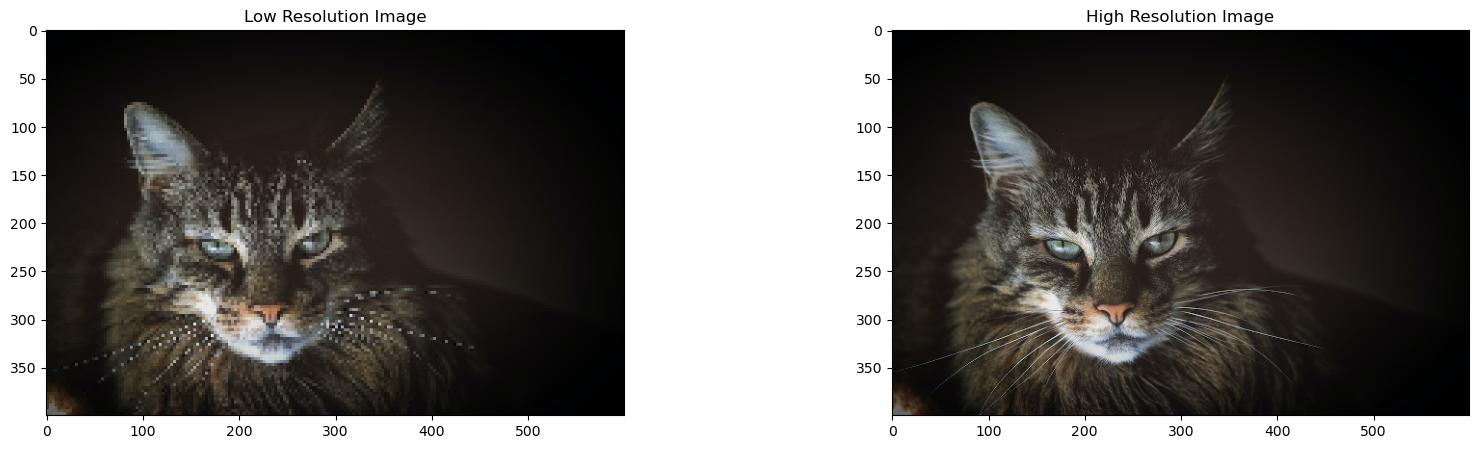

In [18]:
n = 0
for i,m in train_generator:
    img,out = i,m

    if n < 1:
        fig, axs = plt.subplots(1 , 2, figsize=(20,5))
        axs[0].imshow(img[0])
        axs[0].set_title('Low Resolution Image')
        axs[1].imshow(out[0])
        axs[1].set_title('High Resolution Image')
        plt.show()
        n+=1
    else:
        break

In [19]:
train_samples = train_hiresimage_generator.samples
val_samples = val_hiresimage_generator.samples

train_img_gen = imageGenerator(train_generator)
val_img_gen = imageGenerator(val_generator)

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
tensorboard = TensorBoard(log_dir='logs')

## Skip connection test

In [21]:
def build_skip_connections_model(input_shape=(800, 1200, 3)):
    # Input layer
    input_img = Input(shape=input_shape)

    # Convolutional layers
    conv1 = Conv2D(16, (3, 3), padding='same', activation='relu')(input_img)
    conv2 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv1)
    conv3 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv2)
    conv4 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv3)
    concat1 = add([conv3, conv4])
    conv5 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv1)
    concat2 = add([concat1, conv5])
    conv6 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat2)
    concat3 = add([concat2, conv6])
    concat4 = add([concat3, conv2])
    conv7 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat4)
    conv8 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv7)
    conv9 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv8)

    # Output layer
    output_img = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(conv9)

    skip_model = Model(input_img, output_img)
    metrics_list = ['accuracy', MeanAbsoluteError(name='mae'), RootMeanSquaredError(name='rmse')]
    skip_model.compile(optimizer='adam', loss='mean_squared_error', metrics=metrics_list)

    return skip_model

In [22]:
skip_model = build_skip_connections_model()

In [23]:
history = skip_model.fit(
    train_img_gen,
    epochs=2,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    steps_per_epoch=train_samples//BATCH_SIZE,
    validation_data=val_img_gen,
    validation_steps=val_samples//BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr_plateau]
)

Epoch 1/2


ResourceExhaustedError: Graph execution error:

Detected at node 'model/conv2d_7/Relu' defined at (most recent call last):
    File "c:\Users\barte\anaconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\barte\anaconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
      app.start()
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\barte\anaconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\barte\anaconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\barte\anaconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\barte\AppData\Local\Temp\ipykernel_12652\392170901.py", line 1, in <module>
      history = skip_model.fit(
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model/conv2d_7/Relu'
OOM when allocating tensor with shape[16,32,400,600] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv2d_7/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1540]

## Unet test

In [24]:
def build_u_net(input_shape=(img_shape[0], img_shape[1], 3)):
    # Input layer
    input_img = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(16, (3, 3), padding='same', activation='relu')(input_img)
    conv2 = Conv2D(16, (3, 3), padding='same', activation='relu')(conv1)
    maxpool1 = MaxPooling2D()(conv2)

    conv3 = Conv2D(32, (3, 3), padding='same', activation='relu')(maxpool1)
    conv4 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv3)
    maxpool2 = MaxPooling2D()(conv4)

    conv5 = Conv2D(64, (3, 3), padding='same', activation='relu')(maxpool2)
    conv6 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv5)

    # Bottleneck
    bottleneck = Conv2D(64, (3, 3), padding='same', activation='relu')(conv6)
    maxpool3 = MaxPooling2D(pool_size=(2, 2))(bottleneck)

    # Decoder
    upsample1 = UpSampling2D()(maxpool3)
    concat1 = concatenate([upsample1, conv5], axis=-1)
    conv7 = Conv2D(64, (3, 3), padding='same', activation='relu')(concat1)
    conv8 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv7)

    upsample2 = UpSampling2D()(conv8)
    concat2 = concatenate([upsample2, conv3], axis=-1)
    conv9 = Conv2D(32, (3, 3), padding='same', activation='relu')(concat2)
    conv10 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv9)

    upsample3 = UpSampling2D()(conv10)
    concat3 = concatenate([upsample3, conv1], axis=-1)
    conv11 = Conv2D(16, (3, 3), padding='same', activation='relu')(concat3)
    conv12 = Conv2D(16, (3, 3), padding='same', activation='relu')(conv11)

    # Output layer
    output_img = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(conv12)

    unet = Model(input_img, output_img)    
    metrics_list = ['accuracy', MeanAbsoluteError(name='mae'), RootMeanSquaredError(name='rmse')]
    unet.compile(optimizer='adam', loss='mean_squared_error', metrics=metrics_list)
    
    return unet

In [25]:
Unet = build_u_net()

In [26]:
history = Unet.fit(
    train_img_gen,
    epochs=2,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    steps_per_epoch=train_samples//BATCH_SIZE,
    validation_data=val_img_gen,
    validation_steps=val_samples//BATCH_SIZE,
    callbacks=[early_stopping, reduce_lr_plateau]
)

Epoch 1/2


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model/conv2d_11/Conv2D/Conv2DBackpropInput' defined at (most recent call last):
    File "c:\Users\barte\anaconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\barte\anaconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
      app.start()
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\barte\anaconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\barte\anaconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\barte\anaconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\barte\AppData\Local\Temp\ipykernel_18252\3373533816.py", line 1, in <module>
      history = Unet.fit(
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model/conv2d_11/Conv2D/Conv2DBackpropInput'
OOM when allocating tensor with shape[20,400,600,48] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model/conv2d_11/Conv2D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1994]

## GAN training

In [19]:
tf.config.run_functions_eagerly(True)

In [20]:
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(BATCH_SIZE)
# val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)

best_val_loss = float('inf')
early_stopping_patience = 10
early_stopping_counter = 0

train_gen_losses = []
train_disc_losses = []
avr_train_gen_losses = []
avr_train_disc_losses = []
val_gen_losses = []
val_disc_losses = []

mae_list = []
mse_list = []
accuracy_list = []

@tf.function
def train_step(X, y):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        real_output = discriminator(y, training=True)
        generated_images = generator(X, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    train_gen_losses.append(gen_loss)
    train_disc_losses.append(disc_loss)

    try:
        mae_list.append(tf.abs(generated_images - y))
        mse_list.append(tf.square(generated_images - y))
        accuracy_list.append(tf.keras.metrics.binary_accuracy(generated_images, y))
    except:
        pass

for epoch in tqdm(range(EPOCHS), desc="Training Epochs", unit="epoch"):
    for batch_X, batch_y in train_img_gen:
        train_step(batch_X, batch_y)

    val_losses = []
    val_mae = []
    val_mse = []
    val_accuracy = []

    for val_batch_X, val_batch_y in val_img_gen:
        val_real_output = discriminator(val_batch_y, training=False)
        val_generated_images = generator(val_batch_X, training=False)
        val_fake_output = discriminator(val_generated_images, training=False)
        val_gen_loss = generator_loss(val_fake_output)
        val_disc_loss = discriminator_loss(val_real_output, val_fake_output)
        val_losses.append((val_gen_loss, val_disc_loss))

    val_mae.append(np.abs(val_real_output.numpy() - val_fake_output.numpy()))
    val_mse.append(np.square(val_real_output.numpy() - val_fake_output.numpy()))
    val_accuracy.append(tf.keras.metrics.binary_accuracy(val_real_output.numpy(), val_fake_output.numpy()))

    avg_val_gen_loss = tf.reduce_mean([loss[0] for loss in val_losses])
    avg_val_disc_loss = tf.reduce_mean([loss[1] for loss in val_losses])
    avr_train_gen_losses.append(tf.reduce_mean(train_gen_losses))
    avr_train_disc_losses.append(tf.reduce_mean(train_disc_losses))

    mae = tf.reduce_mean(mae_list)
    mse = tf.reduce_mean(mse_list)
    accuracy = tf.reduce_mean(accuracy_list)
    val_gen_losses.append(avg_val_gen_loss)
    val_disc_losses.append(avg_val_disc_loss)

    val_mae = np.array(val_mae)

    print(f"Epoch {epoch + 1}, "
          f"Average Training Generator Loss: {avr_train_gen_losses[-1]}, "
          f"Average Training Discriminator Loss: {avr_train_disc_losses[-1]}, "
          f"Average Validation Generator Loss: {avg_val_gen_loss}, "
          f"Average Validation Discriminator Loss: {avg_val_disc_loss}, "
          f"Average Training MAE: {mae}, "
          f"Average Training MSE: {mse}, "
          f"Average Training Accuracy: {accuracy}"
          f"Average Validation MAE: {tf.reduce_mean(val_mae)}, "
          f"Average Validation MSE: {tf.reduce_mean(val_mse)}, "
          f"Average Validation Accuracy: {tf.reduce_mean(val_accuracy)}",
          )
    
    mae_list = []
    mse_list = []
    accuracy_list = []

    if avg_val_gen_loss < best_val_loss:
        best_val_loss = avg_val_gen_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter == early_stopping_patience:
        print(f"Early stopping at epoch {epoch + 1} due to no improvement in validation loss.")
        generator.load_weights('best_generator_weights.h5')
        discriminator.load_weights('best_discriminator_weights.h5')
        break

    train_img_gen.reset()
    val_img_gen.reset()

print("Finished!")

Training Epochs:   0%|          | 0/100 [00:00<?, ?epoch/s]c:\Users\barte\anaconda3\envs\tf\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
Training Epochs:   0%|          | 0/100 [04:02<?, ?epoch/s]


ResourceExhaustedError: {{function_node __wrapped__Conv2DBackpropInput_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[1,200,300,80] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2DBackpropInput]

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(avr_train_gen_losses, label='Training Generator Loss')
plt.plot(avr_train_disc_losses, label='Training Discriminator Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(val_gen_losses, label='Validation Generator Loss')
plt.plot(val_disc_losses, label='Validation Discriminator Loss')
plt.title('Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
plot_predictions(generator, X_train, y_train)

In [ ]:
plot_predictions(generator, X_test, y_test)